# Техническое задание Маркетинг

## Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

## Цель
Предсказать вероятность покупки в течение 90 дней

## Задачи
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование


### Результат
Репозиторий на гитхабе:
- тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и тестированием
- описание проекта и инструкция по использованию в файле README.md
- список зависимостей в файле requirements.txt

### Стэк
- python
- pandas
- sklearn

# Описание данных


### apparel-purchases
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как
обработать такие случаи – можете предлагать свои варианты решения.
- **client_id** - идентификатор клиента
- **quantity** - количество единиц товара
- **price** - цена товара
- **category_ids** - идентификаторы категорий
- **date** - дата покупки
- **message_id** - идентификатор сообщения из рассылки


### apparel-messages
Рассылки, которые были отправлены клиентам из таблицы покупок.
- **bulk_campaign_id** - идентификатор рассылки
- **client_id** - идентификатор клиента
- **message_id** - идентификатор сообщения
- **event** - действие с сообщением (отправлено, открыто, покупка…)
- **channel** - канал рассылки
- **date** - дата действия
- **created_at** - дата-время полностью 


### target
- **client_id** - идентификатор клиента
- **target** - клиент совершил покупку в целевом периоде

Общая база рассылок огромна, поэтому собрали для вас агрегированную по дням
статистику по рассылкам. Если будете создавать на основе этой статистики дополнительные
признаки, обратите внимание, что нельзя суммировать по колонкам nunique, потому что это
уникальные клиенты в пределах дня, у вас нет данных, повторяются ли они в другие дни)


### full_campaign_daily_event
Агрегация общей базы рассылок по дням и типам событий
- **date** - дата
- **bulk_campaign_id** - идентификатор рассылки
- **count_event** - общее количество каждого события event
- **nunique_event** - количество уникальных client_id в каждом событии

В именах колонок все типы событий event


### full_campaign_daily_event_channel
Агрегация по дням с учетом событий и каналов рассылки
- **date** - дата
- **bulk_campaign_id** - идентификатор рассылки
- **count_event_channel** - общее количество каждого события по каналам
- **nunique_event_channel** - количество уникальных client_id по событиям и каналам

В именах колонок есть все типы событий event и каналов рассылки channel

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report
from catboost import CatBoostClassifier
import optuna

In [49]:
apparel_purchases = pd.read_csv('/Users/valardoh/Documents/ЯНДЕКС_ПРАКТИКУМ_DS/Мастерская_2/filtered_data/apparel-purchases.csv')
apparel_messages = pd.read_csv('/Users/valardoh/Documents/ЯНДЕКС_ПРАКТИКУМ_DS/Мастерская_2/filtered_data/apparel-messages.csv')
apparel_target_binary = pd.read_csv('/Users/valardoh/Documents/ЯНДЕКС_ПРАКТИКУМ_DS/Мастерская_2/filtered_data/apparel-target_binary.csv')

In [50]:
display(apparel_purchases)
display(apparel_messages)
display(apparel_target_binary)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


# Датафрейм apparel_purchases - Данные о покупках клиентов

In [51]:
apparel_purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [52]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [53]:
print("=== Пропуски ===")
print(apparel_purchases.isna().sum())
print("\n=== Дубликаты ===")
print("Общее количество дубликатов:", apparel_purchases.duplicated().sum())

=== Пропуски ===
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

=== Дубликаты ===
Общее количество дубликатов: 73020


In [54]:
apparel_purchases[apparel_purchases.duplicated()].head(50)

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
63,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
79,1515915625468178854,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468178854-4439-62834151a12f2
88,1515915625468221626,1,1999.0,"['2', '18', '212', '726']",2022-05-17,1515915625468221626-4439-628341394ee14
104,1515915625471111919,1,79.0,"['2', '17', '173', '1598']",2022-05-17,1515915625471111919-4439-62834130b5e38
106,1515915625471143578,1,1799.0,"['4', '28', '260', '420']",2022-05-17,1515915625471143578-4439-6283415a428e4


In [55]:
apparel_purchases.price.unique()

array([ 1999.,  2499.,  6499., ..., 15904.,  9500., 13173.])

In [56]:
apparel_purchases['price'] = apparel_purchases['price'].astype('int64')
apparel_purchases['date'] = pd.to_datetime(apparel_purchases['date'], format='%Y-%m-%d')

In [57]:
apparel_purchases[apparel_purchases['price'] >= 10000]

,client_id,quantity,price,category_ids,date,message_id
2898,1515915625478090454,1,10999,"['5562', '5558', '5559', '1094']",2022-05-24,1515915625478090454-4517-628b2d995976c
6018,1515915625692218402,1,48499,"['4', '29', '312', '1576']",2022-06-01,1515915625489907961-4679-62972222453b3
12994,1515915625494529950,1,16499,"['4', '29', '313', '1574']",2022-06-10,1515915625494529950-4832-62a1969869bb0
23467,1515915625815661387,1,11999,"['5562', '5558', '5559', '1094']",2022-07-13,1515915625815661387-5439-62cec1e96ff2f
24373,1515915625489947869,1,19499,"['4', '29', '310', '500']",2022-07-16,1515915625489947869-5112-62b580d8232f3
...,...,...,...,...,...,...
201499,1515915625995466015,1,36999,"['4', '29', '310', '1577']",2024-02-14,1515915625488243479-14641-65cb23e8dc49b
201528,1515915626007437082,1,15904,"['4', '29', '313', '1574']",2024-02-14,1515915625953187492-14488-65a79766e8625
201529,1515915626007437082,1,15904,"['4', '29', '313', '1574']",2024-02-14,1515915625953187492-14488-65a79766e8625
201664,1515915625807230542,1,13173,"['5562', '5683', '5572', '1011']",2024-02-15,1515915625489389564-14624-65c5e2639975d


In [58]:
apparel_purchases = apparel_purchases.drop(apparel_purchases[apparel_purchases['price'] >= 10000].index)

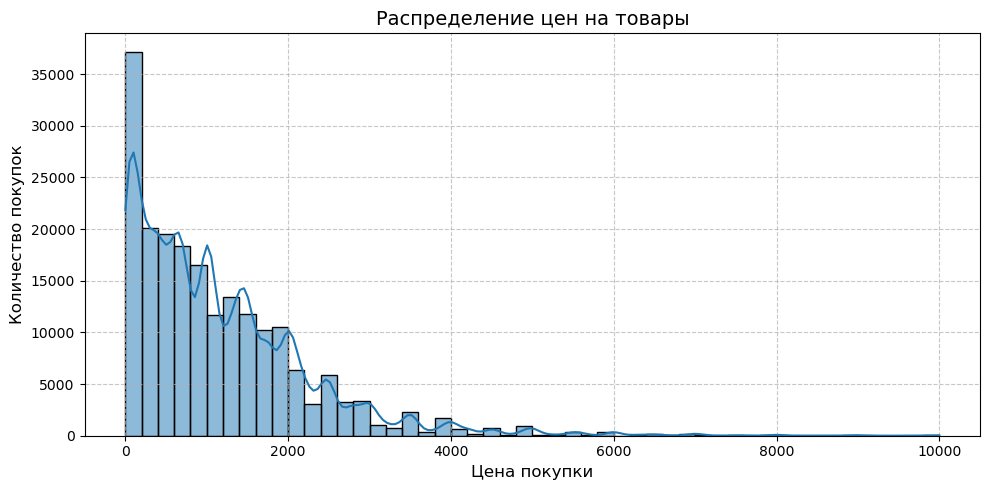

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=apparel_purchases['price'], bins=50, kde=True, ax=ax)

ax.set_xlabel('Цена покупки', fontsize=12)
ax.set_ylabel('Количество покупок', fontsize=12)
ax.set_title('Распределение цен на товары', fontsize=14)

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [60]:
apparel_purchases[apparel_purchases['quantity'] >= 5]

,client_id,quantity,price,category_ids,date,message_id
21424,1515915625559762595,10,2,"['5562', '5597', '5691', '889']",2022-07-08,1515915625471544776-5335-62c7d2c4cc9fd
21425,1515915625559762595,10,2,"['5562', '5597', '5691', '889']",2022-07-08,1515915625471544776-5335-62c7d2c4cc9fd
23702,1515915625540239255,25,2,"['5562', '5597', '5691', '889']",2022-07-14,1515915625540239255-5403-62ce6dd7d68a1
23866,1515915625740853027,20,2,"['5562', '5597', '5691', '889']",2022-07-14,1515915625491240655-5403-62ce6db70596e
23867,1515915625740853027,20,2,"['5562', '5597', '5691', '889']",2022-07-14,1515915625491240655-5403-62ce6db70596e
26557,1515915625509511395,25,4,"['5562', '5597', '5691', '889']",2022-07-27,1515915625509511395-5623-62df9127ce354
26558,1515915625509511395,13,4,"['5562', '5597', '5691', '889']",2022-07-27,1515915625509511395-5623-62df9127ce354
34820,1515915625491476744,10,6,"['5562', '5597', '5691', '889']",2022-08-30,1515915625491476744-6223-630c908c2e345
37005,1515915625548883766,30,2,"['5562', '5597', '5691', '889']",2022-09-06,1515915625548883766-6283-6316e248bbbf9
67945,1515915625892804258,15,3,"['4', '1822', '1821', '1613']",2022-12-16,1515915625566723180-8722-639c17d50f223


In [61]:
purchases_target = pd.merge(
    apparel_purchases,
    apparel_target_binary,
    on = 'client_id',
    how = 'left',
)

purchases_target

,client_id,quantity,price,category_ids,date,message_id,target
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0
...,...,...,...,...,...,...,...
201871,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0
201872,1515915626010439406,1,99,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0
201873,1515915626010439406,1,99,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0
201874,1515915626010443527,1,1999,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,0


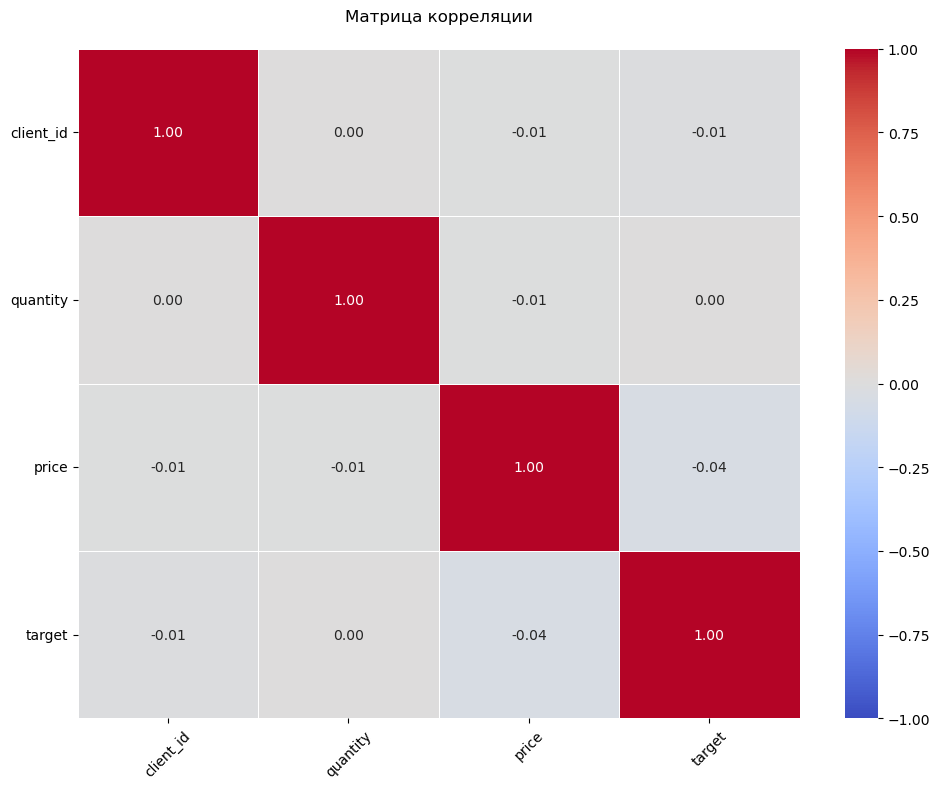

In [62]:
numeric_cols = purchases_target.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'target' in purchases_target.columns and 'target' not in numeric_cols:
    numeric_cols.append('target')

corr_matrix = purchases_target[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    vmin=-1,
    vmax=1
)

plt.title('Матрица корреляции', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод:**

Проведен исследовательский анализ данных датафрейма данных о покупках клиентов (apparel_purchases). Пропусков не обнаружено. Найдено 72900 дубликатов. В основном клиент покупает 1 товар, дубликаты удалять не стану. Заменил тип данных в колонке price с float на int, так как все цены - целое число. Так же заменил в колонке date тип данных на datetime. Остальные типы соответствуют колонкам. Удалил цены товара, которые превышают 10000. Построил график для цены товара. Большое количество товара дешевое. В конце объединил этот датафрейм с таргетом. Построил матрицу корреляции, данные никак не коррелируют.

# Датафрейм apparel_messages - Рассылки, которые были отправлены клиентам из таблицы покупок.

In [63]:
apparel_messages

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


In [64]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [65]:
print("=== Пропуски ===")
print(apparel_messages.isna().sum())
print("\n=== Дубликаты ===")
print("Общее количество дубликатов:", apparel_messages.duplicated().sum())

=== Пропуски ===
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

=== Дубликаты ===
Общее количество дубликатов: 48610


In [66]:
apparel_messages[apparel_messages.duplicated()].head(50)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967282,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967567,5723,1515915625753898206,1515915625753898206-5723-62e2af0a21ecd,click,mobile_push,2022-07-28,2022-07-28 16:12:24
967904,5723,1515915625626349443,1515915625626349443-5723-62e2af09c0fd3,click,mobile_push,2022-07-28,2022-07-28 16:15:02
967938,5723,1515915625646938266,1515915625646938266-5723-62e2af09dde3e,click,mobile_push,2022-07-28,2022-07-28 16:18:23
967962,5723,1515915625591285393,1515915625591285393-5723-62e2af09ab0bb,click,mobile_push,2022-07-28,2022-07-28 16:20:36
968069,5723,1515915625471183369,1515915625471183369-5723-62e2af078221f,click,mobile_push,2022-07-28,2022-07-28 16:38:53
968076,5723,1515915625575043419,1515915625575043419-5723-62e2af09423a8,click,mobile_push,2022-07-28,2022-07-28 16:39:48
968198,5723,1515915625489431148,1515915625489431148-5723-62e2af07e03a7,click,mobile_push,2022-07-28,2022-07-28 17:11:45


In [67]:
apparel_messages = apparel_messages.drop_duplicates()

In [68]:
apparel_messages['date'] = pd.to_datetime(apparel_messages['date'], format='%Y-%m-%d')
apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'], format='%Y-%m-%d %H:%M:%S')

/var/folders/mg/l7b9q_3n6255cy3y2nvkp3qm0000gn/T/ipykernel_1512/3003144108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apparel_messages['date'] = pd.to_datetime(apparel_messages['date'], format='%Y-%m-%d')
/var/folders/mg/l7b9q_3n6255cy3y2nvkp3qm0000gn/T/ipykernel_1512/3003144108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'], format='%Y-%m-%d %H:%M:%S')


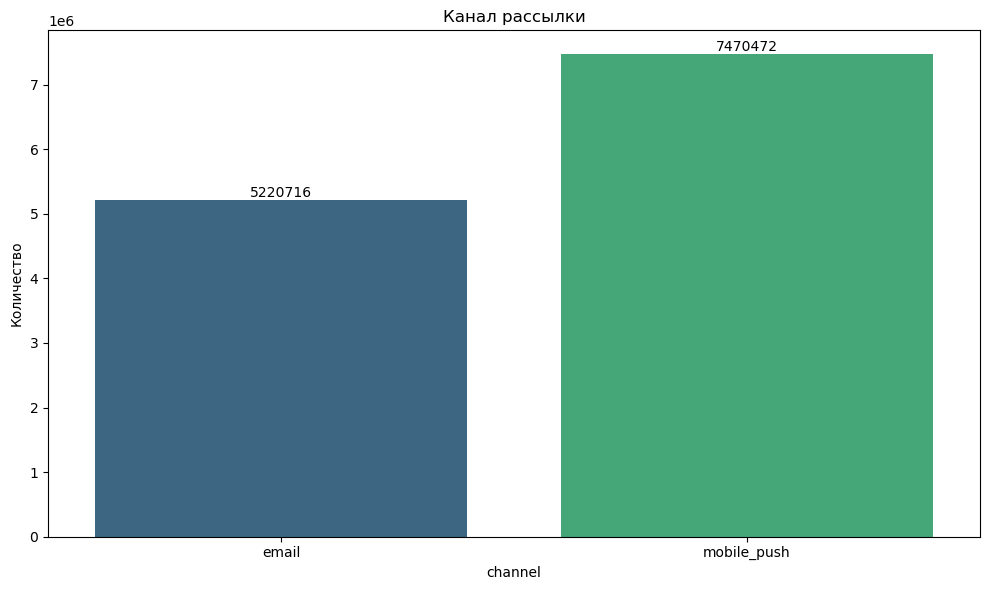

In [69]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=apparel_messages, 
    x='channel', 
    hue='channel',
    palette='viridis',
    legend=False
)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title('Канал рассылки')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

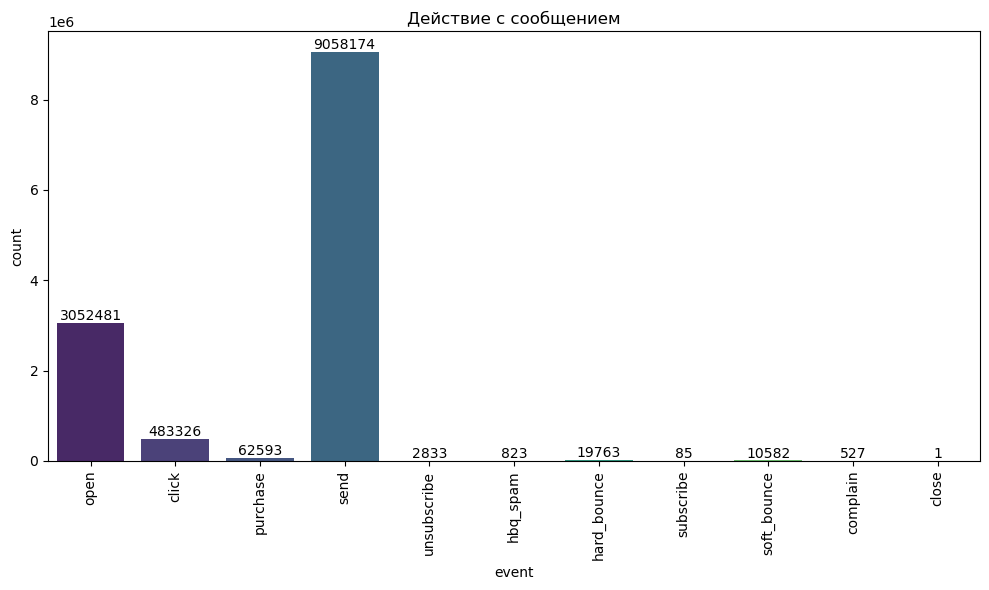

In [70]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=apparel_messages, 
    x='event', 
    hue='event',
    palette='viridis', 
    legend=False
)

plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title('Действие с сообщением')
plt.tight_layout()
plt.show()

In [71]:
messages_target = pd.merge(
    apparel_messages,
    apparel_target_binary,
    on = 'client_id',
    how = 'left',
)

messages_target['target'] = messages_target['target'].astype('Int64')

messages_target

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,target
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,1
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,0
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,0
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,0
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,0
...,...,...,...,...,...,...,...,...
12691183,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40,0
12691184,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20,0
12691185,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40,0
12691186,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40,0


In [72]:
messages_target.isna().sum()

bulk_campaign_id          0
client_id                 0
message_id                0
event                     0
channel                   0
date                      0
created_at                0
target              1777991
dtype: int64

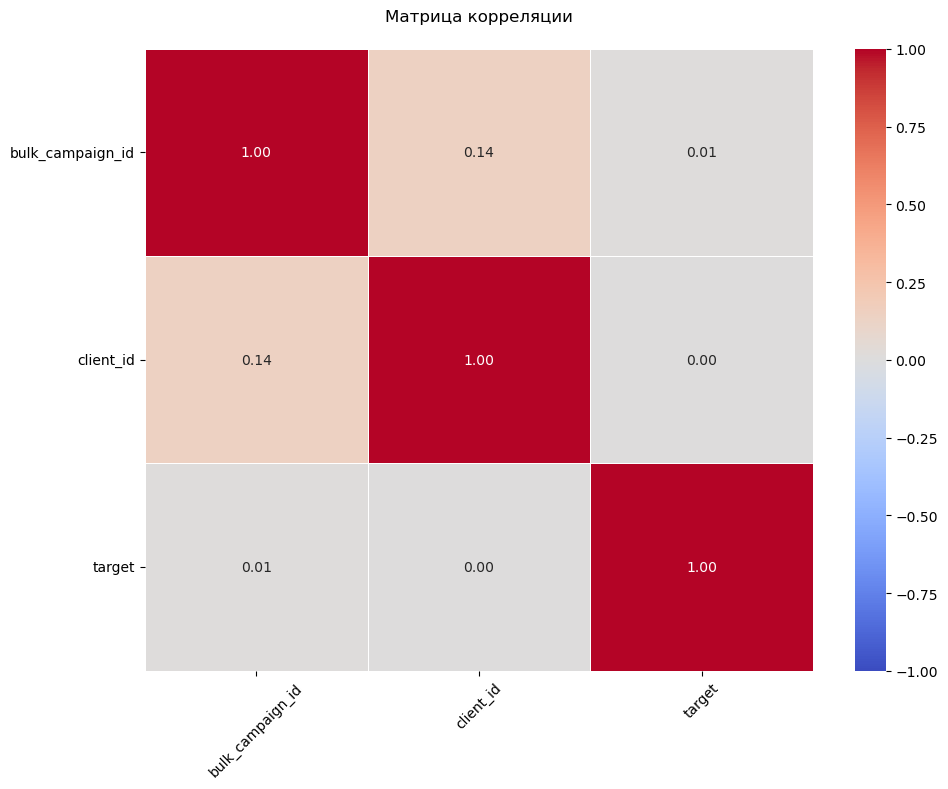

In [73]:
numeric_cols = messages_target.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'target' in messages_target.columns and 'target' not in numeric_cols:
    numeric_cols.append('target')

corr_matrix = messages_target[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    vmin=-1,
    vmax=1
)

plt.title('Матрица корреляции', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод:**

Проведен исследовательский анализ данных с датафреймом рассылки, которые были отправлены клиентам из таблицы покупок (apparel_messages). Пропусков не обнаружено. Выявлено 48610 дубликатов. Удаляю их, так как для такого количества строк в датафрейме (12739798) это незначительная потеря. Поменял тип данных на datetime в колонках date и created_at. Остальные колонки имеют нормальный тип данных. Построил countplot для наглядности в признаках канала рассылок (channel) - тут привышает количество мобильных рассылок, и действий с сообщением (event) - огромное количество send.  В конце объединил с таргетом. Построил матрицу корреляции. Данные не коррелируют. 


# Объединение датафреймов purchases_target с messages_target по client_id и message_id

In [74]:
display(purchases_target)
display(messages_target)

,client_id,quantity,price,category_ids,date,message_id,target
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0
...,...,...,...,...,...,...,...
201871,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0
201872,1515915626010439406,1,99,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0
201873,1515915626010439406,1,99,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0
201874,1515915626010443527,1,1999,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,0


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,target
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,1
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,0
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,0
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,0
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,0
...,...,...,...,...,...,...,...,...
12691183,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40,0
12691184,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20,0
12691185,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40,0
12691186,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40,0


In [75]:
agg_dfs = pd.merge(
    purchases_target,
    messages_target,
    on = ['client_id', 'message_id'],
    how='inner',
    suffixes=('_purchases', '_messages')
)

In [76]:
agg_dfs

,client_id,quantity,price,category_ids,date_purchases,message_id,target_purchases,bulk_campaign_id,event,channel,date_messages,created_at,target_messages
0,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,0,4172,open,email,2022-05-27,2022-05-27 07:52:08,0
1,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,0,2090,click,email,2023-04-12,2023-04-12 08:25:33,0
2,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,0,2090,click,email,2023-04-18,2023-04-18 11:47:45,0
3,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,0,2090,click,email,2023-06-13,2023-06-13 11:10:41,0
4,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,0,2090,click,email,2023-12-28,2023-12-28 11:25:50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780170,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,14648,open,mobile_push,2024-02-15,2024-02-15 07:08:38,0
780171,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,14648,click,mobile_push,2024-02-15,2024-02-15 16:23:39,0
780172,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,14648,send,mobile_push,2024-02-15,2024-02-15 07:08:21,0
780173,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,14648,open,mobile_push,2024-02-15,2024-02-15 07:08:38,0


In [77]:
agg_dfs.target_messages.value_counts()

target_messages
0    750018
1     30157
Name: count, dtype: Int64

In [78]:
discrepancies = agg_dfs[agg_dfs['target_purchases'] != agg_dfs['target_messages']]
print(f"Количество строк с расхождениями: {len(discrepancies)}")

Количество строк с расхождениями: 0


In [79]:
agg_dfs = agg_dfs.drop('target_purchases', axis=1).rename(columns={'target_messages':'target'})

In [80]:
agg_dfs

,client_id,quantity,price,category_ids,date_purchases,message_id,bulk_campaign_id,event,channel,date_messages,created_at,target
0,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172,open,email,2022-05-27,2022-05-27 07:52:08,0
1,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,2023-04-12 08:25:33,0
2,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-18,2023-04-18 11:47:45,0
3,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-06-13,2023-06-13 11:10:41,0
4,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-12-28,2023-12-28 11:25:50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
780170,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,open,mobile_push,2024-02-15,2024-02-15 07:08:38,0
780171,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,click,mobile_push,2024-02-15,2024-02-15 16:23:39,0
780172,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,send,mobile_push,2024-02-15,2024-02-15 07:08:21,0
780173,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,open,mobile_push,2024-02-15,2024-02-15 07:08:38,0


In [81]:
agg_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780175 entries, 0 to 780174
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         780175 non-null  int64         
 1   quantity          780175 non-null  int64         
 2   price             780175 non-null  int64         
 3   category_ids      780175 non-null  object        
 4   date_purchases    780175 non-null  datetime64[ns]
 5   message_id        780175 non-null  object        
 6   bulk_campaign_id  780175 non-null  int64         
 7   event             780175 non-null  object        
 8   channel           780175 non-null  object        
 9   date_messages     780175 non-null  datetime64[ns]
 10  created_at        780175 non-null  datetime64[ns]
 11  target            780175 non-null  Int64         
dtypes: Int64(1), datetime64[ns](3), int64(4), object(4)
memory usage: 72.2+ MB


In [82]:
print("=== Пропуски ===")
print(agg_dfs.isna().sum())
print("\n=== Дубликаты ===")
print("Общее количество дубликатов:", agg_dfs.duplicated().sum())

=== Пропуски ===
client_id           0
quantity            0
price               0
category_ids        0
date_purchases      0
message_id          0
bulk_campaign_id    0
event               0
channel             0
date_messages       0
created_at          0
target              0
dtype: int64

=== Дубликаты ===
Общее количество дубликатов: 278782


In [83]:
agg_dfs[agg_dfs.duplicated()]

,client_id,quantity,price,category_ids,date_purchases,message_id,bulk_campaign_id,event,channel,date_messages,created_at,target
5,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,2023-04-12 08:25:33,0
6,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-18,2023-04-18 11:47:45,0
7,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-06-13,2023-06-13 11:10:41,0
8,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-12-28,2023-12-28 11:25:50,0
11,1515915625566606509,1,299,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d,4301,open,email,2022-06-01,2022-06-01 08:15:21,0
...,...,...,...,...,...,...,...,...,...,...,...,...
780170,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,open,mobile_push,2024-02-15,2024-02-15 07:08:38,0
780171,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,click,mobile_push,2024-02-15,2024-02-15 16:23:39,0
780172,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,send,mobile_push,2024-02-15,2024-02-15 07:08:21,0
780173,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,open,mobile_push,2024-02-15,2024-02-15 07:08:38,0


In [84]:
agg_dfs = agg_dfs.drop_duplicates()

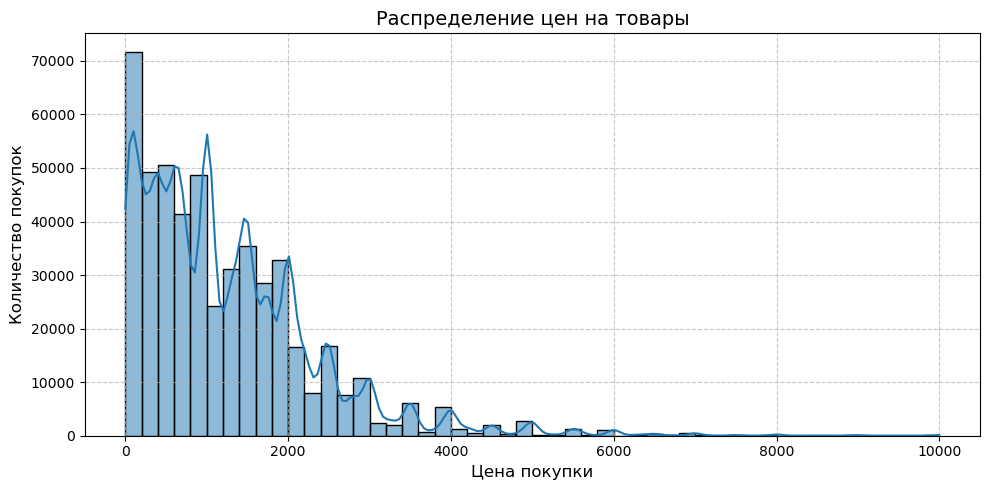

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(data=agg_dfs['price'], bins=50, kde=True, ax=ax)

ax.set_xlabel('Цена покупки', fontsize=12)
ax.set_ylabel('Количество покупок', fontsize=12)
ax.set_title('Распределение цен на товары', fontsize=14)

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

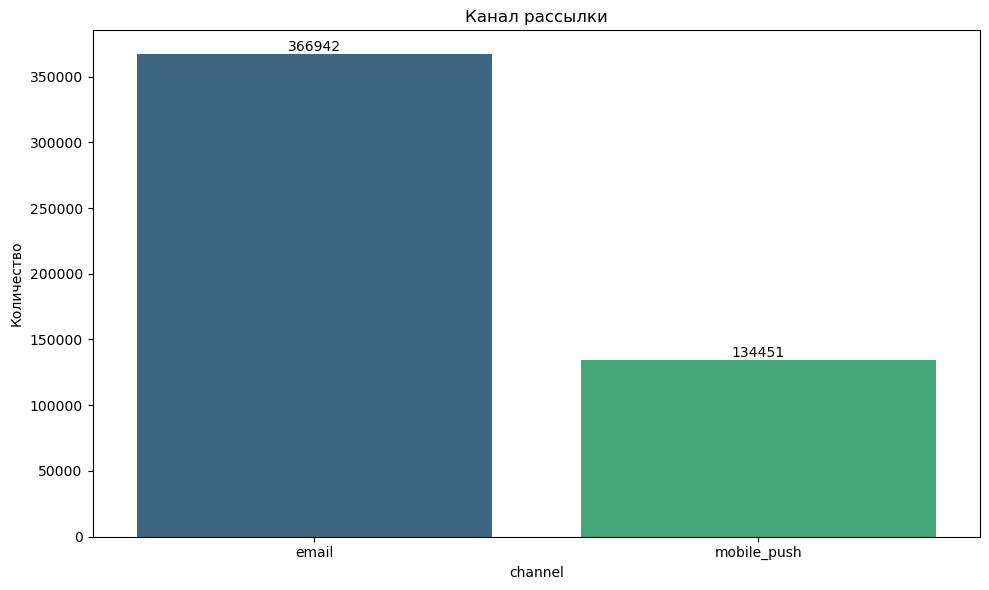

In [86]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=agg_dfs, 
    x='channel', 
    hue='channel',
    palette='viridis',
    legend=False
)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title('Канал рассылки')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

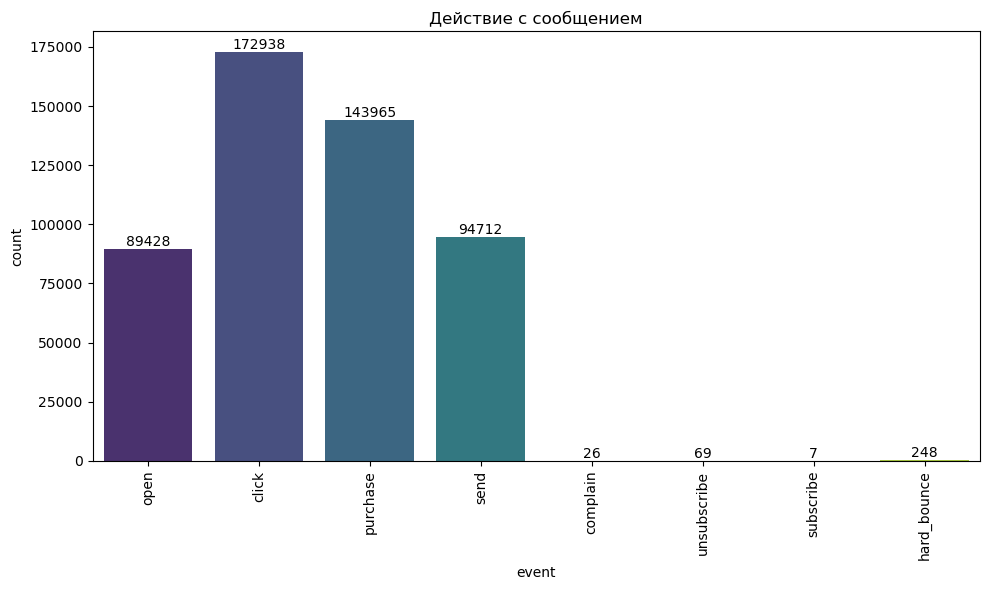

In [87]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=agg_dfs, 
    x='event', 
    hue='event',
    palette='viridis', 
    legend=False
)

plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title('Действие с сообщением')
plt.tight_layout()
plt.show()

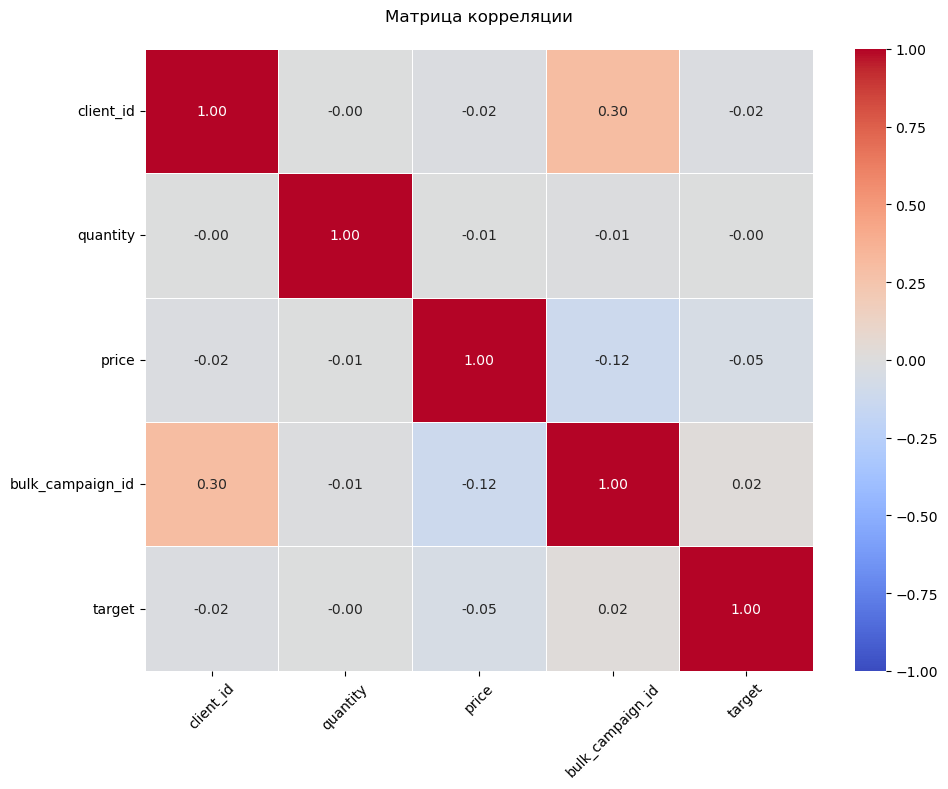

In [88]:
numeric_cols = agg_dfs.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'target' in agg_dfs.columns and 'target' not in numeric_cols:
    numeric_cols.append('target')

corr_matrix = agg_dfs[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    vmin=-1,
    vmax=1
)

plt.title('Матрица корреляции', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод:**

Объединил датафреймы purchases_target с messages_target по client_id и message_id. После чего проверил на расхождение таргетов. Было обнаружено 278782 дубликатов, удалил их. По рассылкам теперь превыщает email в 3 раза. По действию с сообщением - click. Матрика корреляции показала совсем небольшую связь между признаками bulk_campaign_id и client_id.

# Подготовка признаков

In [ ]:
# Проверка на распродажу
agg_dfs['is_sale'] = agg_dfs['category_ids'].apply(lambda x: 1 if 'sale' in str(x).lower() else 0)

# Разница между покупкой и сообщением
agg_dfs['days_s_message'] = (agg_dfs['date_purchases'] - agg_dfs['date_messages']).dt.days

# Частота покупок по клиенту
purchase_fr = agg_dfs.groupby('client_id')['date_purchases'].count().reset_index()
purchase_fr.columns = ['client_id', 'purchase_frequency']
agg_dfs = agg_dfs.merge(purchase_fr, on='client_id', how='left')

# event признаки
agg_dfs['event_opened'] = (agg_dfs['event'] == 'opened').astype(int)
agg_dfs['event_clicked'] = (agg_dfs['event'] == 'clicked').astype(int)
agg_dfs['event_purchase'] = (agg_dfs['event'] == 'purchase').astype(int)
agg_dfs['event_send'] = (agg_dfs['event'] == 'send').astype(int)
agg_dfs['event_complain'] = (agg_dfs['event'] == 'complain').astype(int)
agg_dfs['event_unsubscribe'] = (agg_dfs['event'] == 'unsubscribe').astype(int)
agg_dfs['event_subscribe'] = (agg_dfs['event'] == 'subscribe').astype(int)
agg_dfs['event_hard_bounce'] = (agg_dfs['event'] == 'hard_bounce').astype(int) 



/var/folders/mg/l7b9q_3n6255cy3y2nvkp3qm0000gn/T/ipykernel_1512/968965932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dfs['is_sale'] = agg_dfs['category_ids'].apply(lambda x: 1 if 'sale' in str(x).lower() else 0)
/var/folders/mg/l7b9q_3n6255cy3y2nvkp3qm0000gn/T/ipykernel_1512/968965932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dfs['days_s_message'] = (agg_dfs['date_purchases'] - agg_dfs['date_messages']).dt.days


In [90]:
agg_dfs

,client_id,quantity,price,category_ids,date_purchases,message_id,bulk_campaign_id,event,channel,date_messages,...,days_s_message,purchase_frequency,event_opened,event_clicked,event_purchase,event_send,event_complain,event_unsubscribe,event_subscribe,event_hard_bounce
0,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172,open,email,2022-05-27,...,-11,1,0,0,0,0,0,0,0,0
1,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,...,-331,4,0,0,0,0,0,0,0,0
2,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-18,...,-337,4,0,0,0,0,0,0,0,0
3,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-06-13,...,-393,4,0,0,0,0,0,0,0,0
4,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-12-28,...,-591,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501388,1515915626009802894,1,769,"['4', '28', '275', '421']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633,open,mobile_push,2024-02-12,...,4,24,0,0,0,0,0,0,0,0
501389,1515915626009802894,1,769,"['4', '28', '275', '421']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633,click,mobile_push,2024-02-15,...,1,24,0,0,0,0,0,0,0,0
501390,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,send,mobile_push,2024-02-15,...,1,3,0,0,0,1,0,0,0,0
501391,1515915626010261344,1,1499,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648,open,mobile_push,2024-02-15,...,1,3,0,0,0,0,0,0,0,0


**Вывод:**

Добавлены признаки: 
- Проверка на распродажу (is_sale)
- Разница между покупкой и сообщением (days_s_message)
- Частота покупок по клиенту
- Признаки по колонке действий с сообщением (event): opened_email – открыл ли клиент письмо (1 если event == 'opened'), clicked_link – кликнул ли на ссылку (1 если event == 'clicked'), и аналогично с event_purchase (покупка), event_send (отправил), event_complain (жалоба), event_unsubscribe (отказался от подписки или нет), event_subscribe (подписался или нет) и event_hard_bounce.

# Подготовка к обучению

In [93]:
display(agg_dfs.head(2))
display(agg_dfs.columns)

,client_id,quantity,price,category_ids,date_purchases,message_id,bulk_campaign_id,event,channel,date_messages,...,days_s_message,purchase_frequency,event_opened,event_clicked,event_purchase,event_send,event_complain,event_unsubscribe,event_subscribe,event_hard_bounce
0,1515915625490739153,1,1999,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172,open,email,2022-05-27,...,-11,1,0,0,0,0,0,0,0,0
1,1515915625491869271,2,599,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090,click,email,2023-04-12,...,-331,4,0,0,0,0,0,0,0,0


Index(['client_id', 'quantity', 'price', 'category_ids', 'date_purchases',
       'message_id', 'bulk_campaign_id', 'event', 'channel', 'date_messages',
       'created_at', 'target', 'is_sale', 'days_s_message',
       'purchase_frequency', 'event_opened', 'event_clicked', 'event_purchase',
       'event_send', 'event_complain', 'event_unsubscribe', 'event_subscribe',
       'event_hard_bounce'],
      dtype='object')

In [98]:
numeric_features = ['quantity', 'price', 'is_sale', 
                    'days_s_message', 'purchase_frequency', 'event_opened', 
                    'event_clicked', 'event_purchase', 'event_send', 
                    'event_complain', 'event_unsubscribe', 'event_subscribe', 'event_hard_bounce']
categorical_features = ['channel']

X = agg_dfs[numeric_features + categorical_features]
y = agg_dfs['target']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Обучение модели CatBoostClassifier и улучшение через optuna

In [106]:
model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_state=42,
    verbose=100
)

model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test))

0:	test: 0.6088601	best: 0.6088601 (0)	total: 14.9ms	remaining: 8.9s
100:	test: 0.7952353	best: 0.7952353 (100)	total: 1.43s	remaining: 7.09s
200:	test: 0.8227502	best: 0.8227502 (200)	total: 2.86s	remaining: 5.69s
300:	test: 0.8364105	best: 0.8364105 (300)	total: 4.25s	remaining: 4.22s
400:	test: 0.8464808	best: 0.8464808 (400)	total: 5.63s	remaining: 2.79s
500:	test: 0.8545273	best: 0.8545273 (500)	total: 7.03s	remaining: 1.39s
599:	test: 0.8608225	best: 0.8608225 (599)	total: 8.4s	remaining: 0us

bestTest = 0.8608224635
bestIteration = 599



In [108]:
def cbc_opt(tr):
    params = {
        'iterations': tr.suggest_int('iterations', 100, 1000),
        'depth': tr.suggest_int('depth', 3, 10),
        'learning_rate': tr.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': tr.suggest_float('l2_leaf_reg', 1, 10),
    }
    
    model = CatBoostClassifier(**params, eval_metric='AUC', random_state=42, verbose=False)
    model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test))
    return model.get_best_score()['validation']['AUC']

In [110]:
study = optuna.create_study(direction='maximize')
study.optimize(cbc_opt, n_trials=30)

[I 2025-07-20 18:41:30,046] A new study created in memory with name: no-name-02b50851-a1c7-4439-8056-38b1495fe35d
[I 2025-07-20 18:41:40,428] Trial 0 finished with value: 0.9130089691512087 and parameters: {'iterations': 547, 'depth': 8, 'learning_rate': 0.27160350891227414, 'l2_leaf_reg': 3.9016734629262264}. Best is trial 0 with value: 0.9130089691512087.
[I 2025-07-20 18:41:56,618] Trial 1 finished with value: 0.9255186051365782 and parameters: {'iterations': 780, 'depth': 9, 'learning_rate': 0.21893527140307625, 'l2_leaf_reg': 4.134879679402669}. Best is trial 1 with value: 0.9255186051365782.
[I 2025-07-20 18:41:59,040] Trial 2 finished with value: 0.8301986853612507 and parameters: {'iterations': 115, 'depth': 9, 'learning_rate': 0.27907039312922727, 'l2_leaf_reg': 8.210193904017748}. Best is trial 1 with value: 0.9255186051365782.
[I 2025-07-20 18:42:03,004] Trial 3 finished with value: 0.8426826844312949 and parameters: {'iterations': 207, 'depth': 5, 'learning_rate': 0.2452152

In [121]:
# best_params = study.best_params
# best_params
print('Лучшие параметры:', study.best_params)
print('Лучшая метрика AUC:', study.best_value)

Лучшие параметры: {'iterations': 991, 'depth': 10, 'learning_rate': 0.22363900521286983, 'l2_leaf_reg': 1.7063247571075464}
Лучшая метрика AUC: 0.9432539751669403


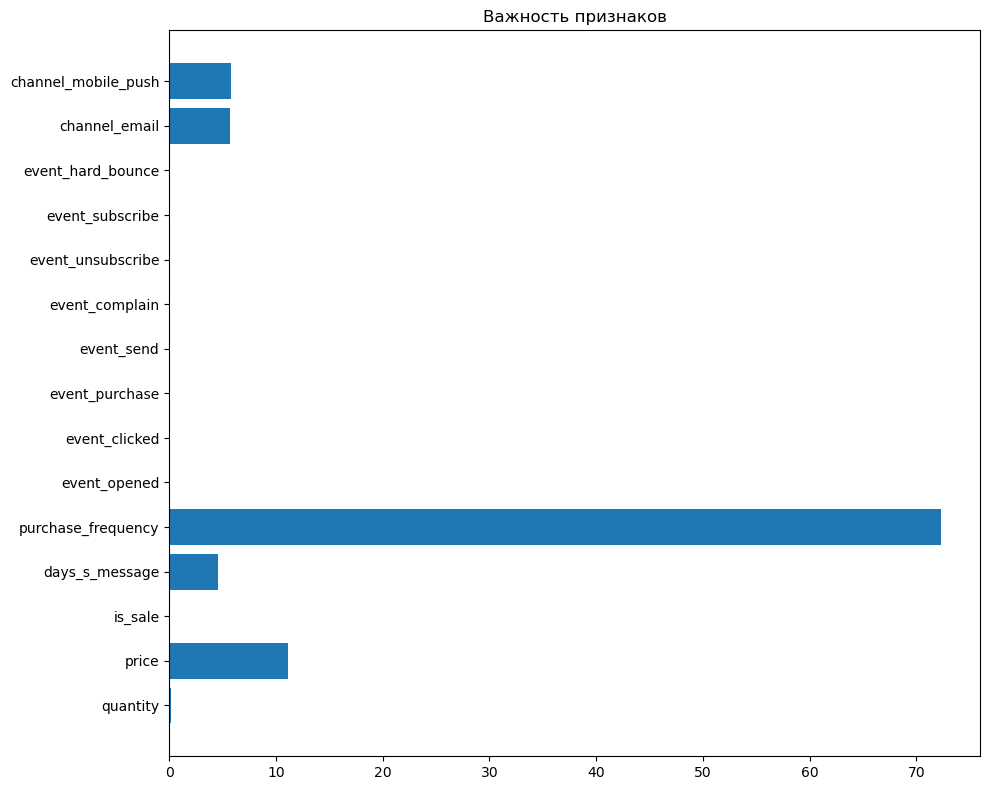

In [ ]:
ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_features)
feature_importance = model.get_feature_importance()

plt.figure(figsize=(10, 8))
plt.barh(all_feature_names, feature_importance)
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

In [ ]:
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, model.predict(X_test_processed)))

ROC-AUC: 0.8608
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     96384
         1.0       0.98      0.37      0.54      3895

    accuracy                           0.98    100279
   macro avg       0.98      0.69      0.76    100279
weighted avg       0.98      0.98      0.97    100279



**Вывод:**

Была обучена модель CatBoostClassifier с параметрами: iterations=600,learning_rate=0.1,depth=6,eval_metric='AUC',random_state=42,verbose=100, которая показала довольно неплохой результат в 0.86. После через гиперпараметр optuna были найдены настройки модели с очень хорошим качеством в 0.94. После построил график важности признаков и он показал, что созданные мной признаки с event и is_sale оказались бесполезные, однако days_s_message немного вляет на предсказание модели и особенно purchase_frequency.